In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def load_data(filename):
    df = pd.read_csv(filename)  # <-- Replace with your actual file path
    waveform_cols = [col for col in df.columns if col.startswith('t')]
    waveforms = df[waveform_cols].values  # shape (N, T)
    return df, waveforms

In [3]:
df, wf = load_data("../data/shiyan/run0006/alltraces.csv")

In [4]:
# Baseline correction
baseline_region = slice(20, 80)  # Adjust if needed

# Subtract the mean of baseline region from each waveform
wf = wf - wf[:, baseline_region].mean(axis=1, keepdims=True)


In [5]:
def plot_waveforms(df, waveforms, indices=None, n_random=None):
    if indices is None:
        if n_random is None:
            raise ValueError("You must provide either 'indices' or 'n_random'.")
        indices = np.random.choice(len(df), size=n_random, replace=False)

    plt.figure(figsize=(12, 6))
    for i in indices:
        plt.plot(waveforms[i], alpha=0.5)
    plt.title(f"{len(indices)} Waveforms (Baseline-Corrected)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


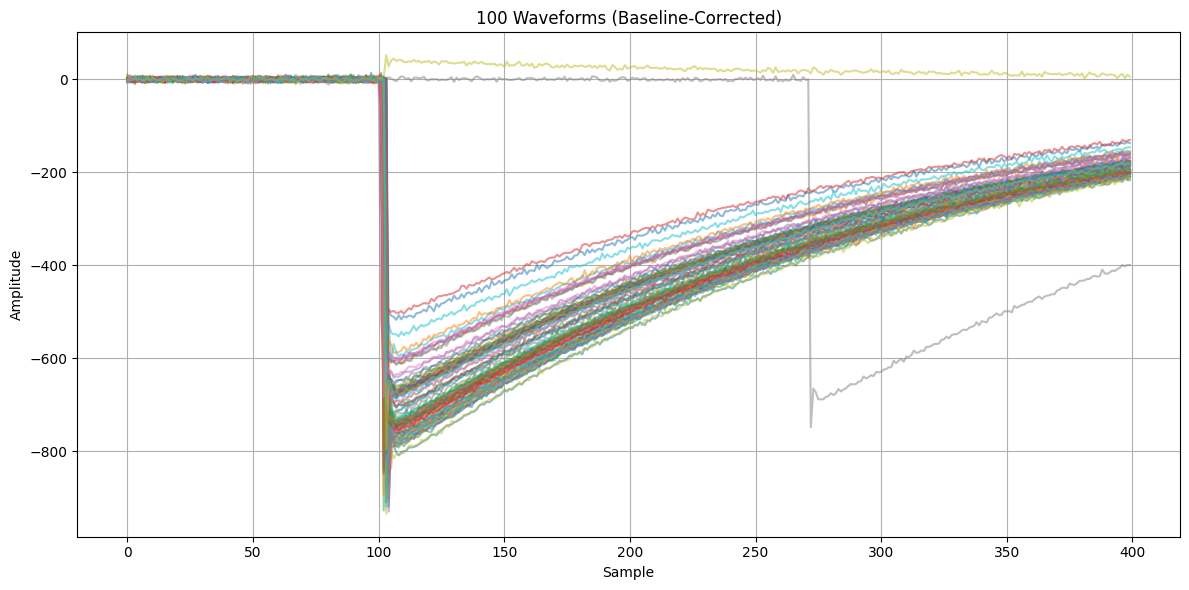

In [6]:
plot_waveforms(df, wf, n_random=100)

In [7]:
def compute_overlaps(df, waveforms):
    # Identify valid waveforms
    norms = np.linalg.norm(waveforms, axis=1)
    valid_mask = norms > 1e-8
    valid_waveforms = waveforms[valid_mask]

    # Average waveform and its normalized version
    avg = np.mean(valid_waveforms, axis=0)
    avg_norm = avg / np.linalg.norm(avg)

    # Normalize waveforms and compute cosine similarity
    normed = valid_waveforms / norms[valid_mask, np.newaxis]
    overlaps = normed @ avg_norm

    # Store overlap values in DataFrame
    df['overlap'] = np.nan
    df.loc[valid_mask, 'overlap'] = overlaps

    return df, avg, overlaps, valid_mask

In [8]:
def plot_strange_waveforms(df, waveforms, overlap_min=0.0, overlap_max=0.5, max_plots=10):
    # Select indices in the specified overlap range
    in_range = df[(df['overlap'] >= overlap_min) & (df['overlap'] <= overlap_max)].index

    print(f"Found {len(in_range)} waveforms with overlap in [{overlap_min}, {overlap_max}]")

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(in_range):
        if i >= max_plots:
            break
        plt.plot(waveforms[idx], alpha=0.5)

    plt.title(f"Up to {max_plots} Waveforms in Overlap Range [{overlap_min}, {overlap_max}]")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_overlap_histogram(df, log_y=True, bins=100):
    overlaps = df['overlap'].dropna()  # remove NaNs if any

    plt.figure(figsize=(10, 5))
    plt.hist(overlaps, bins=bins)
    plt.xlabel('Cosine Similarity to Average')
    plt.ylabel('Count')
    plt.title('Overlap Distribution')

    if log_y:
        plt.yscale('log')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
df, avg, overlaps, valid_mask = compute_overlaps(df, wf)

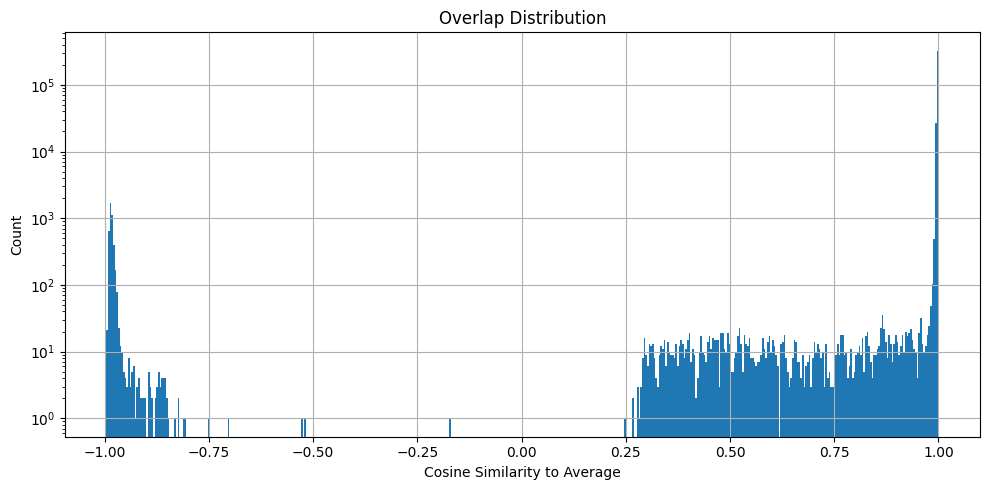

In [16]:
plot_overlap_histogram(df, log_y=True,bins=500)

Found 1628 waveforms with overlap in [0, 0.9]


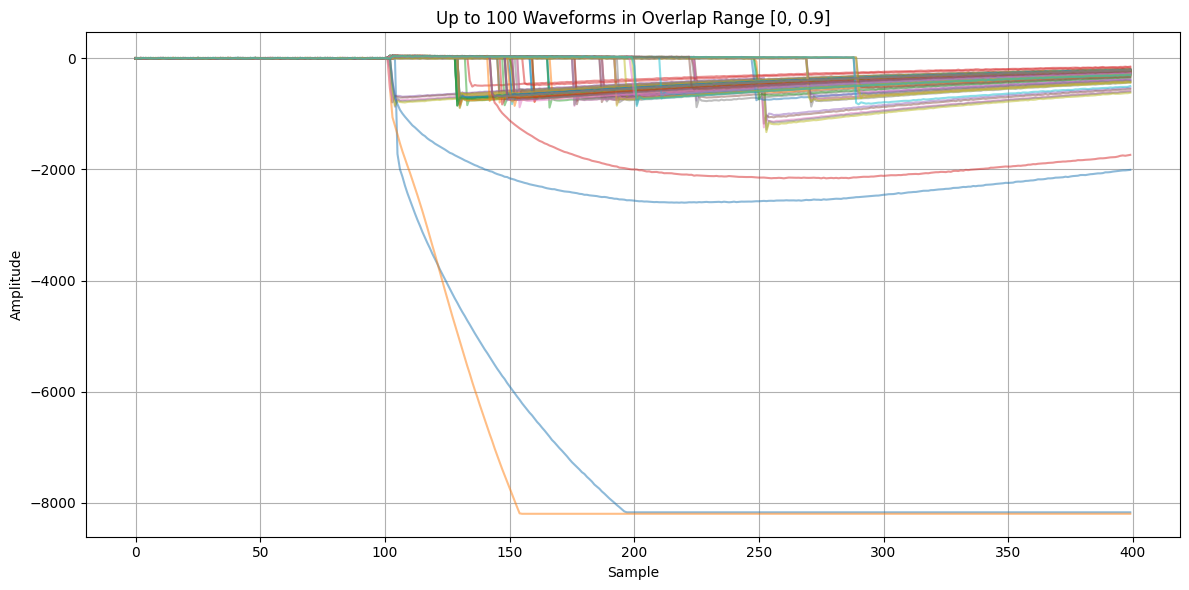

In [21]:
plot_strange_waveforms(df, wf, overlap_min=0, overlap_max=0.9, max_plots=100)

In [13]:
def get_strange_event_groups(df, overlap_min=0.0, overlap_max=0.5):
    # Step 1: Find event_IDs with strange waveforms
    strange_df = df[(df['overlap'] >= overlap_min) & (df['overlap'] <= overlap_max)]
    strange_event_ids = strange_df['event_ID'].unique()

    print(f"Found {len(strange_event_ids)} unique events with strange hits.")

    # Step 2: Collect all hits (rows) from those events
    grouped = df[df['event_ID'].isin(strange_event_ids)].copy()

    return grouped, strange_event_ids

In [22]:
grouped_df, strange_event_ids = get_strange_event_groups(df, overlap_min=0.25, overlap_max=0.9)

Found 449 unique events with strange hits.


In [23]:
for event_id in strange_event_ids[:5]:  # first 5 events
    hits = grouped_df[grouped_df['event_ID'] == event_id]
    print(f"\nEvent {event_id} has {len(hits)} hits:")
    display(hits[['layer', 'x', 'y', 'MWD', 'overlap']])


Event 100 has 4 hits:


,layer,x,y,MWD,overlap
106,1,2,0,141.424,0.997147
107,2,2,0,143.430,0.995113
108,3,2,0,185.603,0.990138
109,4,2,0,557.758,0.848857



Event 2391 has 5 hits:


,layer,x,y,MWD,overlap
1791,1,1,1,87.6684,0.998874
1792,2,1,1,93.5481,0.998495
1793,3,1,1,603.1150,0.865618
1794,4,1,1,100.2180,0.996196
1795,5,1,1,100.5240,0.998937



Event 4507 has 7 hits:


,layer,x,y,MWD,overlap
2920,1,0,1,91.45580,0.999098
2921,2,0,1,97.24210,0.999215
2922,3,0,1,92.26420,0.998694
2923,3,1,1,14.87720,0.850162
2924,4,0,1,92.43090,0.996645
2925,4,1,1,4.04789,0.836003
2926,5,0,1,100.01800,0.999053



Event 4664 has 8 hits:


,layer,x,y,MWD,overlap
3139,1,2,2,84.4388,0.998593
3140,1,0,2,26.7120,0.866538
3141,2,0,2,32.3943,0.870236
3142,2,2,2,91.9932,0.996364
3143,3,0,2,27.8773,0.864352
3144,3,2,2,91.3077,0.998697
3145,4,0,2,32.0973,0.869889
3146,5,0,2,33.7408,0.875990



Event 4841 has 10 hits:


,layer,x,y,MWD,overlap
3375,1,2,2,4.67345,0.790256
3376,1,3,0,86.75500,0.998006
3377,2,2,2,4.84191,0.790622
3378,2,3,0,93.99200,0.999095
3379,3,2,2,5.17050,0.789340
3380,3,3,0,99.06550,0.998995
3381,4,3,0,98.25870,0.998634
3382,4,2,2,5.31784,0.782189
3383,5,2,2,5.07365,0.786586
3384,5,3,0,95.98490,0.999013
